Unified for all the PT regions

In [1]:
from categoriesDef import categories
cat = categories['high']
version = 'v10addPlots'
mB_var = 'mass_candB'

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, DSetLoader
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass

In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [6]:
webFolder = '/storage/user/ocerri/public_html/BPH_RDst/calibrationPtB0_JpsiKst/'+version+'/'
if not os.path.isdir(webFolder):
    os.makedirs(webFolder)
    os.system('cp {v}../index.php {v}'.format(v=webFolder))

# Load data

In [7]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_200622*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
if not lumi_tot:
    expectedLumi = {'Low':6.4, 'Mid':20., 'High':26.} #fb^-1
    lumi_tot = expectedLumi[cat.name]
    print 'Total lumi (estimated): {:.1f} fb^-1'.format(lumi_tot)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu12_IP6_part2_v2 5.27
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu12_IP6_part1_v2 5.3
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu12_IP6_part4_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu12_IP6_part3_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200622
HLT_Mu12_IP6_part0_v2 5.25
Total lumi: 26.40 fb^-1


In [8]:
dsetRD_loc = '../data/cmsRD/skimmed/B2JpsiKst_200622_{}_corr.root'.format(cat.name)

fRD_skimmed = rt.TFile.Open(dsetRD_loc, 'READ')
tRD_skimmed = fRD_skimmed.Get('Tevts')

N_sel_per_fb = tRD_skimmed.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 4051


# Analyze data

### Fit the whole dataset

In [9]:
width = 0.003 #GeV
m_min = 5.201
m_max = 5.36
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=np.arange(start=m_min, stop=m_max, step=width)
               )
tRD_skimmed.Project('h', mB_var)
h.Sumw2()

In [10]:
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar(mB_var, 'm_{#mu#mu#piK}', m_min, m_max, 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.01, 0.0005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.03, 0.005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [11]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [12]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
dN_sig_per_fb = nsig.getError()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

chi2: 61.3/46 0.065
Total: Nsig = 61386, Nbkg = 12081
Signal events per fb: 2325


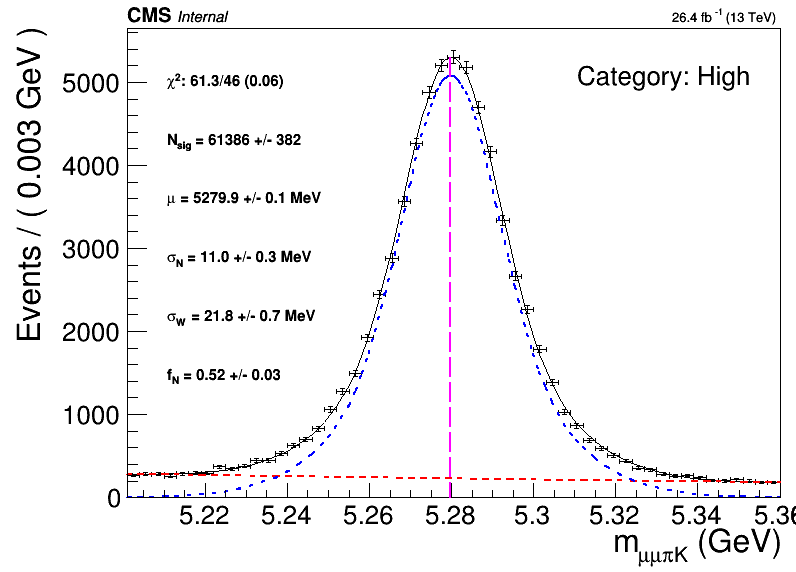

In [13]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/MassMuMuPiK_data_' + cat.name + '_' + version + '.png')
c.SaveAs(webFolder+'MassMuMuPiK_data_' + cat.name + '_' + version + '.png')

### Make sDataset

In [14]:
v_trgMu_pt = rt.RooRealVar('trgMu_pt', 'trg #mu p_{T}', 0, 500, 'GeV')
v_otherMu_pt = rt.RooRealVar('otherMu_pt', 'trg #mu p_{T}', 0, 500, 'GeV')
v_trgMu_eta = rt.RooRealVar('trgMu_eta', 'trg #mu #eta', -3, 3, '')
v_K_pt = rt.RooRealVar('K_pt', 'K p_{T}', 0, 500, 'GeV')
v_pi_pt = rt.RooRealVar('pi_pt', '#pi p_{T}', 0, 500, 'GeV')
v_Jpsi_pt = rt.RooRealVar('Jpsi_pt', 'J/#psi p_{T}', 0, 500, 'GeV')
v_Kst_pt = rt.RooRealVar('Kst_pt', 'K* p_{T}', 0, 500, 'GeV')
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_N_vtx = rt.RooRealVar('N_vtx', 'N_{vtx}', 0, 1e3)
# Displacement related quantities
v_sigdxy_vtxB_PV = rt.RooRealVar('sigdxy_vtxB_PV', 'd_{xy}/#sigma_{xy}', 0, 1e4)
v_pval_mumupiK = rt.RooRealVar('pval_mumupiK', 'p-val vtx #mu#mu#piK', 0, 2)

ss = rt.RooArgSet(mass, v_trgMu_pt, v_trgMu_eta, 
                  v_K_pt, v_pi_pt,
                  v_Jpsi_pt, v_Kst_pt,
                  v_B_eta, v_B_pt)
ss.add(v_N_vtx)
ss.add(v_otherMu_pt)
ss.add(v_sigdxy_vtxB_PV)
ss.add(v_pval_mumupiK)

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', tRD_skimmed, ss)
ds.convertToTreeStore()

In [15]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

61418.65548665652

In [16]:
f_sw = rt.TFile(dsetRD_loc.replace('.root', '_sw.root'), 'RECREATE')
ds.convertToTreeStore()
auxTree = ds.tree()
auxTree.Write()
f_sw.Close()

In [17]:
dfRD = pd.DataFrame(rtnp.root2array(dsetRD_loc.replace('.root', '_sw.root')))
dfRD['sigSW'] = dfRD['L_nsig']/(dfRD['L_nsig']+dfRD['L_nbkg'])

# Load MC

In [18]:
mcSample = DSetLoader('B0_JpsiKst_PUc0', candDir='ntuples_B2JpsiKst')
# dsetMC_loc = mcSample.skimmed_dir + '/{}_corr.root'.format(cat.name)
dsetMC_loc = mcSample.skimmed_dir + '/{}_bare.root'.format(cat.name)

dfMC = pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [19]:
effMCgen = mcSample.effMCgen
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))['JPsiKst']
effCAND = mcSample.effCand['effCAND']
effSkim = mcSample.getSkimEff(cat.name+'_bare')

xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND, effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'


Expected evts/fb: 430 +/- 12




In [20]:
from pileup_utilities import pileupReweighter
puRew = pileupReweighter(dsetMC_loc, cat)
dfMC['wPU'] = puRew.weightsPileupMC[dfMC['N_vtx'].astype(np.int)]

# Compare

### Closure variables

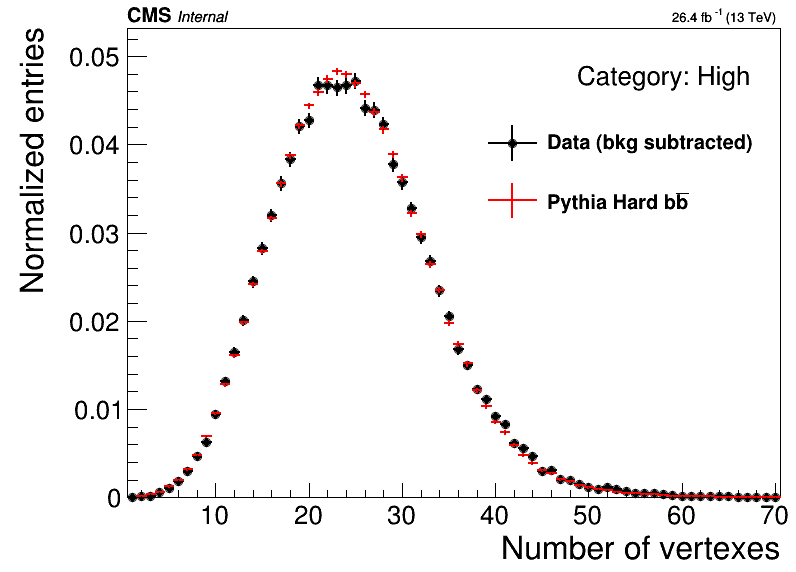

In [21]:
hRD = create_TH1D(dfRD['N_vtx'], name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=[70, 0.5, 70.5],
                weights=dfRD['sigSW'],
                scale_histo='norm'
               )
hRD.SetMarkerStyle(15)

hMC = create_TH1D(dfMC['N_vtx'], name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning,
                  weights=dfMC['wPU'],
                  scale_histo='norm' 
                 )
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.6, 0.6, 0.95,0.8)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.integrated_lumi = lumi_tot
m = SetMaxToMaxHist([hRD, hMC])
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name));

### Load MC corrections

In [22]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v8base.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
        
nX = hTriggerSF.GetNbinsX()
ptWeight = [[] for k in range(nX+2)]

dfMC['trgSF'] = np.ones(dfMC.shape[0])
for i, (pt, eta, ip) in enumerate(dfMC[['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy']].values):
    ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
    iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
    iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
    dfMC.at[i, 'trgSF'] = hTriggerSF.GetBinContent(ix, iy, iz)
    if np.abs(dfMC.at[i, 'trgSF'] - 1) > 0.1:
        print (4*'{:.2f} ').format(pt, eta, ip, hTriggerSF.GetBinContent(ix, iy, iz))
    ptWeight[ix].append(hTriggerSF.GetBinContent(ix, iy, iz))

14.44 -1.33 7.14 1.15 
15.69 -0.96 7.03 1.15 
14.11 -1.49 7.57 1.15 
14.67 -1.39 7.17 1.15 
15.24 -0.84 7.83 1.15 
14.81 0.81 7.54 1.15 
15.44 -1.03 7.80 1.15 
14.10 -1.48 7.96 1.15 
14.57 -1.29 7.27 1.15 
15.63 -0.94 7.63 1.15 
15.15 -1.19 7.57 1.15 
15.96 0.98 7.85 1.15 
14.25 1.05 7.22 1.15 
14.54 -1.09 7.25 1.15 
14.59 -1.17 7.69 1.15 
14.78 -0.99 7.86 1.15 
14.18 1.37 7.27 1.15 
14.09 -0.99 7.95 1.15 
14.41 1.36 7.87 1.15 
15.62 0.93 7.27 1.15 
15.24 1.19 7.26 1.15 
14.45 -0.99 7.94 1.15 
15.82 1.04 7.59 1.15 
15.01 1.31 7.01 1.15 
14.22 -1.02 7.60 1.15 
15.13 -1.29 7.09 1.15 
15.56 1.24 7.84 1.15 
15.31 0.88 7.57 1.15 
14.60 1.33 7.06 1.15 
14.97 -1.41 7.21 1.15 
15.55 1.17 7.89 1.15 
14.24 1.32 7.13 1.15 
15.42 0.95 7.04 1.15 
14.93 1.23 7.03 1.15 
15.38 -1.28 7.31 1.15 
14.96 1.26 7.81 1.15 
15.40 -1.05 7.16 1.15 
14.18 -1.09 7.67 1.15 
14.51 1.09 7.82 1.15 
15.51 -1.24 7.18 1.15 
15.22 -0.97 7.11 1.15 
14.68 -1.23 7.59 1.15 
15.16 1.39 7.70 1.15 
14.01 -0.92 7.99 1.15 
14.96 -

15.02 -0.80 7.72 1.15 
14.44 0.95 7.87 1.15 
14.71 1.07 7.34 1.15 
14.02 1.39 7.84 1.15 
14.90 1.16 7.21 1.15 
15.69 0.89 7.92 1.15 
14.70 -1.20 7.06 1.15 
14.36 1.26 7.70 1.15 
14.54 1.00 7.52 1.15 
15.50 1.26 7.31 1.15 
14.24 0.97 7.73 1.15 
14.44 1.21 7.52 1.15 
15.41 1.08 7.80 1.15 
14.11 0.94 7.36 1.15 
14.42 1.03 7.89 1.15 
14.62 -1.47 7.06 1.15 
14.19 1.01 7.14 1.15 
15.30 -0.94 7.72 1.15 
15.41 0.81 7.76 1.15 
14.58 -1.41 7.26 1.15 
14.18 -1.03 7.61 1.15 
15.20 -1.23 7.54 1.15 
15.62 1.18 7.94 1.15 
14.72 -0.88 7.65 1.15 
14.25 -1.41 7.49 1.15 
15.12 1.02 7.94 1.15 
15.50 1.43 7.50 1.15 
14.10 -1.43 7.74 1.15 
14.37 -0.83 7.53 1.15 
14.05 1.44 7.36 1.15 
15.02 -1.02 7.67 1.15 
15.96 1.06 7.24 1.15 
14.46 -0.80 7.34 1.15 
15.10 1.21 7.18 1.15 
15.61 1.09 7.78 1.15 
14.85 1.34 7.73 1.15 
15.12 -0.89 7.91 1.15 
15.41 -1.45 7.93 1.15 
15.82 1.42 7.29 1.15 
14.07 -0.98 7.48 1.15 
14.89 0.85 7.47 1.15 
15.13 0.81 7.07 1.15 
14.83 -1.41 7.92 1.15 
14.58 -1.50 7.23 1.15 
14.91 0.99 7.3

14.59 -0.91 7.73 1.15 
14.88 1.07 7.30 1.15 
16.00 1.15 7.47 1.15 
14.85 -1.19 7.03 1.15 
15.63 1.37 7.79 1.15 
15.73 1.34 7.15 1.15 
15.43 -0.87 7.09 1.15 
15.52 1.21 7.23 1.15 
14.16 1.00 7.89 1.15 
15.65 1.08 7.57 1.15 
14.66 0.87 7.51 1.15 
15.32 -1.11 7.97 1.15 
15.52 1.06 7.05 1.15 
14.15 1.25 7.95 1.15 
15.96 1.17 7.86 1.15 
15.70 -0.93 7.36 1.15 
14.50 0.87 7.62 1.15 
15.68 -1.17 7.89 1.15 
14.83 -0.92 7.67 1.15 
14.86 -1.05 7.67 1.15 
15.04 1.43 7.03 1.15 
14.05 -1.31 7.66 1.15 
14.73 1.05 7.64 1.15 
14.08 -1.23 7.71 1.15 
15.71 -1.41 7.59 1.15 
15.66 1.40 7.71 1.15 
15.05 -0.98 7.01 1.15 
14.59 -0.82 7.62 1.15 
14.28 1.38 7.31 1.15 
15.80 1.47 7.72 1.15 
14.19 1.13 7.27 1.15 
15.64 1.33 7.31 1.15 
14.55 1.18 7.61 1.15 
15.05 -1.20 7.63 1.15 
14.78 0.84 7.45 1.15 
15.01 -1.27 7.51 1.15 
15.83 1.14 7.45 1.15 
14.51 1.22 7.92 1.15 
15.85 0.93 7.91 1.15 
15.39 -1.36 7.55 1.15 
14.32 1.19 7.99 1.15 
15.36 -1.41 7.80 1.15 
15.81 -1.43 7.22 1.15 
14.45 -1.28 7.51 1.15 
14.91 1.35 7.

14.76 -1.39 7.70 1.15 
15.59 -1.05 7.66 1.15 
15.66 1.24 7.32 1.15 
14.75 -0.82 7.33 1.15 
14.65 -0.90 7.24 1.15 
14.90 1.25 7.08 1.15 
15.46 1.13 7.43 1.15 
14.59 -1.24 7.69 1.15 
14.26 -1.43 7.46 1.15 
14.08 -1.43 7.59 1.15 
15.01 -0.99 7.09 1.15 
15.28 1.26 7.31 1.15 
15.85 0.91 7.82 1.15 
15.47 -1.11 7.27 1.15 
15.75 1.27 7.34 1.15 
14.04 0.83 7.45 1.15 
14.36 0.81 7.40 1.15 
15.11 -1.43 7.75 1.15 
14.04 0.94 7.63 1.15 
14.12 -1.20 7.46 1.15 
14.61 1.04 7.73 1.15 
14.52 -1.17 7.65 1.15 
14.65 1.33 7.57 1.15 
15.92 -0.90 7.63 1.15 
14.59 1.11 7.47 1.15 
14.77 1.07 7.32 1.15 
15.89 -0.88 7.89 1.15 
15.25 0.94 7.64 1.15 
14.38 0.88 7.04 1.15 
16.00 0.81 7.38 1.15 
14.01 -1.07 7.97 1.15 
14.20 -0.80 7.02 1.15 
14.53 -1.14 7.62 1.15 
14.41 -0.90 7.10 1.15 
14.13 -1.20 7.57 1.15 
14.23 -1.25 7.72 1.15 
14.89 -1.46 7.33 1.15 
15.66 1.46 7.03 1.15 
15.91 1.01 7.27 1.15 
14.45 1.13 7.16 1.15 
14.41 1.20 7.60 1.15 
15.87 -0.91 7.87 1.15 
14.67 -1.37 7.89 1.15 
16.00 -1.17 7.67 1.15 
14.84 0.

In [23]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

dfMC['muonSF'] = np.ones(dfMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(dfMC[['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta']].values):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    dfMC.at[i, 'muonSF'] = wp * wm

In [24]:
dfMC['w'] = dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF']

In [25]:
print 'MC purity: {:.1f}%'.format(100*np.sum(dfMC['MC_idxMatch'] == 1)/float(dfMC['MC_idxMatch'].shape[0]))

MC purity: 98.9%


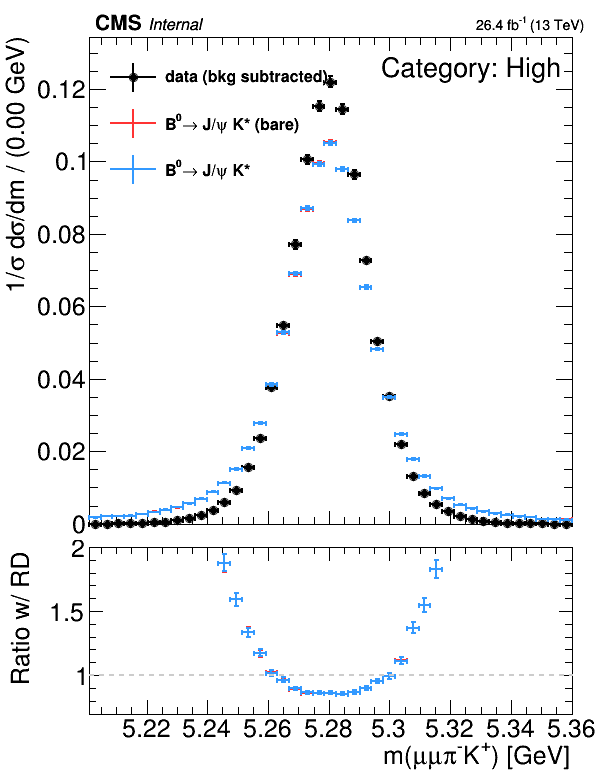

In [26]:
b=[41, m_min, m_max]
hRD = create_TH1D(dfRD[mB_var], name='hRD', title='RD',
                  weights=dfRD['sigSW'],
                  axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                  binning=b,
                  scale_histo='norm',
                 )
hRD.SetMarkerStyle(15)

hMCbare = create_TH1D(dfMC[mB_var], name='hMCbare',
                  title = 'Pythia Hard b#bar{b}',
                  scale_histo='norm', color=1,
                  binning=hRD.binning)
    
hMC = create_TH1D(dfMC[mB_var], name='hMC',
                  weights=dfMC['w'],
                  scale_histo='norm', color=0,
                  binning=hRD.binning)

leg = rt.TLegend(0.17, 0.75, 0.6,0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(hRD, 'data (bkg subtracted)', 'lep')
leg.AddEntry(hMCbare, 'B^{0}#rightarrow J/#psi K* (bare)', 'le')
leg.AddEntry(hMC, 'B^{0}#rightarrow J/#psi K*', 'le')

CMS_lumi.extraText = 7*' ' + 'Internal'
CMS_lumi.integrated_lumi = lumi_tot
c = make_ratio_plot([hRD, hMCbare, hMC], leg_pos=None, ratio_bounds=[0.7,2])
c.pad1.SetTopMargin(0.07)
CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
catText.DrawLatexNDC(0.95, 0.9, 'Category: {}'.format(cat.name))
leg.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/massComaprison_' + cat.name + '_' + version + '.png')
c.SaveAs(webFolder+'massComaprison_' + cat.name + '_' + version + '.png')

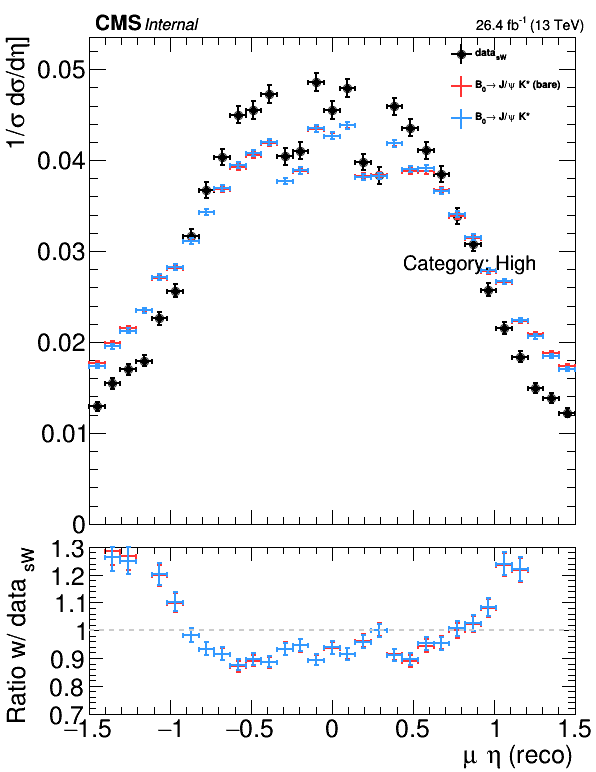

In [27]:
hRD = create_TH1D(dfRD['trgMu_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['#mu #eta (reco)', 
                              '1/#sigma d#sigma/d#eta]'],
                  binning=[31,-1.5,1.5],
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['trgMu_eta'], name='hMCb',
                  title = 'B_{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['trgMu_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   weights=dfMC['wPU']*dfMC['muonSF']*dfMC['trgSF'],
#                   weights=dfMC['trgSF'],
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 1.3], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
# cr.pad2.SetLogy()
cr.leg.SetY2(0.93)
cr.leg.SetY1(0.75)
cr.leg.SetX1(0.75)
cr.leg.SetX2(0.94)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/trgMuEtaComaprison_' + cat.name + '_' + version + '.png')
cr.SaveAs(webFolder+'trgMuEta_' + cat.name + '_' + version + '.png')

In [144]:
def drawPt(var, binning, xtitle, saveTag='', withBptCorr=False, loglog=True, testWeights=True):
    binWdith = binning[1] - binning[0]
    hRD = create_TH1D(dfRD[var], name='hRD',
                      weights=dfRD['nsig_sw'],
                      title='data_{sW}',
                      axis_title=[xtitle, 
                                  '1/#sigma d#sigma/dp_{T}'],
                      binning=binning,
                      scale_histo='norm',
                      widthNorm=True,
                      opt='overflow+underflow'
                     )
    hRD.SetMarkerStyle(15)

    hMCb = create_TH1D(dfMC[var], name='hMCb',
                      title = 'B^{0}#rightarrow J/#psi K* (bare)',
                      scale_histo='norm',
                      widthNorm=True,
                      color=1,
                      binning=hRD.binning, opt='overflow+underflow')

    hMC = create_TH1D(dfMC[var], name='hMC', 
                      weights=dfMC['w'],
                      title = 'B^{0}#rightarrow J/#psi K*',
                      scale_histo='norm',
                      widthNorm=True,
                      color=0,
                      binning=hRD.binning, opt='overflow+underflow')
    
    h_list = [hRD, hMCb, hMC]
    if testWeights:
        hMCtest = create_TH1D(dfMC[var], name='hMCtest', 
                      weights=dfMC['wTest'],
                      title = 'B^{0}#rightarrow J/#psi K* (test)',
                      scale_histo='norm',
                      widthNorm=True,
                      color=3,
                      binning=hRD.binning, opt='overflow+underflow')
        h_list.append(hMCtest)
    
    if withBptCorr:
        hMCc = create_TH1D(dfMC[var], name='hMCc', 
                      weights=cal_pT.getWeights(dfMC['MC_B_pt'], 0)*dfMC['w'],
                      title = 'B^{0}#rightarrow J/#psi K* (p_{T} cal.)',
                      scale_histo='norm', color=2,
                      widthNorm=True,
                      binning=hRD.binning, opt='underflow+overflow')
        h_list.append(hMCc)

    CMS_lumi.extraText = '      Internal'
    cr = make_ratio_plot(h_list, ratio_bounds=[0.7, 1.2], draw_opt='E1')
    CMS_lumi.CMS_lumi(cr, -1, 0)
    cr.pad1.SetTopMargin(0.07)
    cr.pad1.SetRightMargin(0.035)
    cr.pad2.SetRightMargin(0.035)
    if cat.name == 'High' and loglog:
        cr.pad1.SetLogx()
        cr.pad2.SetLogx()
    cr.leg.SetY2(0.93)
    cr.leg.SetY1(0.75)
    cr.leg.SetX1(0.6)
    cr.Draw()

    cr.pad1.cd()
    catText.SetTextSize(0.04)
    catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
    cr.dnd2 = h_list
    if saveTag and not testWeights:
        cr.SaveAs('../data/calibration/B0pTspectrum/fig/'+saveTag+'_' + cat.name + '_' + version + '.png')
        cr.SaveAs(webFolder+saveTag+'_' + cat.name + '_' + version + '.png')
    return cr

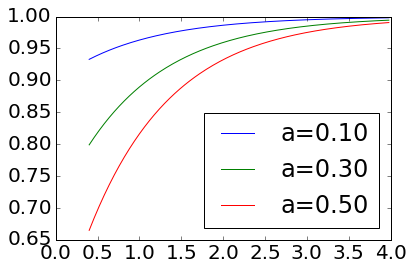

In [174]:
x = np.arange(0.4, 4, 0.02)

# def fArb(xIn, a=0.5, delta=0, tau=0.5):
    
#     x = -(xIn-delta)/tau
#     y = a*np.where(x>0, x, (np.exp(x)-1))
#     return -y + 1 - a

def fArb(xIn, a=0.5, tau=0.8):
    return 1 - a*np.exp(-xIn/tau)

for a in [0.1, 0.3, 0.5]:
    plt.plot(x, fArb(x, a=a, tau=1), label='a={:.2f}'.format(a))
plt.legend(loc='best')

In [143]:
dfMC['wTest'] = dfMC['w']
dfMC['wTest'] *= fArb(dfMC['K_pt'])
dfMC['wTest'] *= fArb(dfMC['pi_pt'])

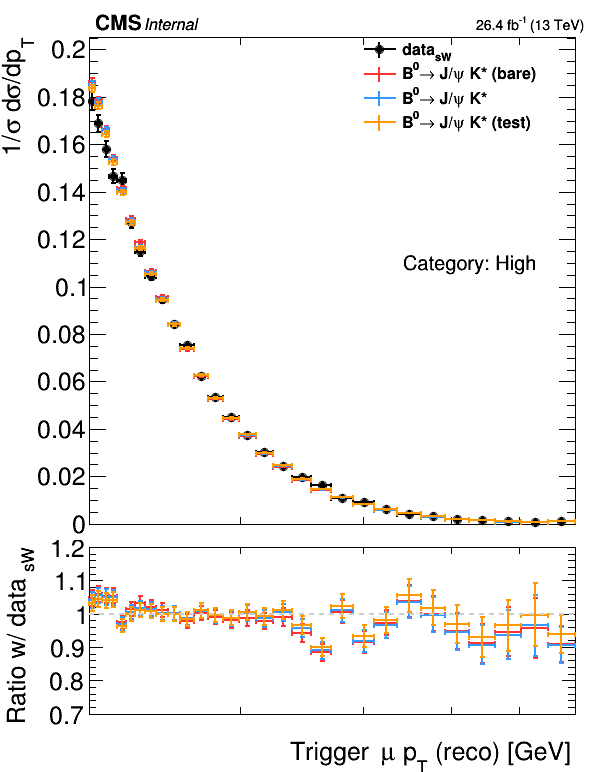

In [145]:
b = {'Low': array('d', list(np.arange(7, 9.4, 0.1)) + [9.4]),
     'Mid': array('d', list(np.arange(9, 12.2, 0.1)) +[12.2]),
     'High': array('d', list(10+np.logspace(np.log10(12.2-10), np.log10(50), 30)))
    }

cr = drawPt('trgMu_pt', b[cat.name], 'Trigger #mu p_{T} (reco) [GeV]', saveTag='trgMuPt_preCal')

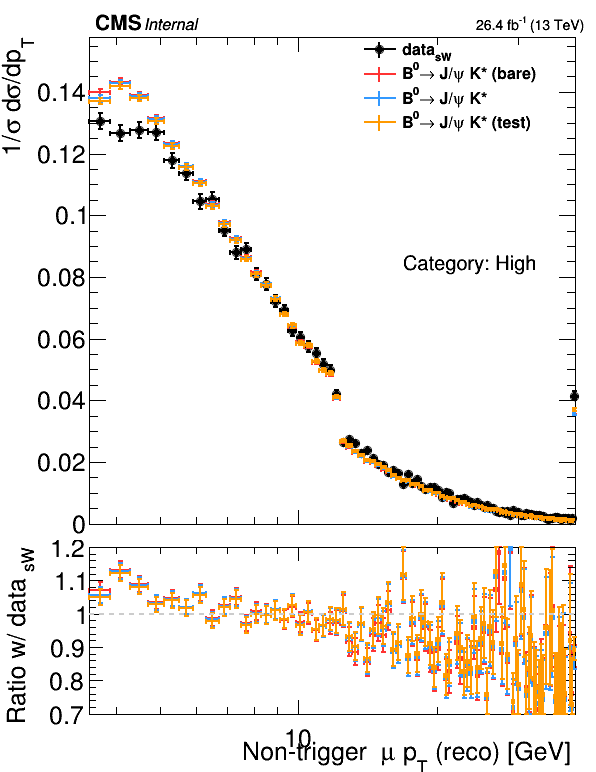

In [146]:
b = array('d', list(np.arange(3.5, 40, 0.4)))
cr = drawPt('otherMu_pt', b, 'Non-trigger #mu p_{T} (reco) [GeV]', saveTag='otherMuPt_preCal')

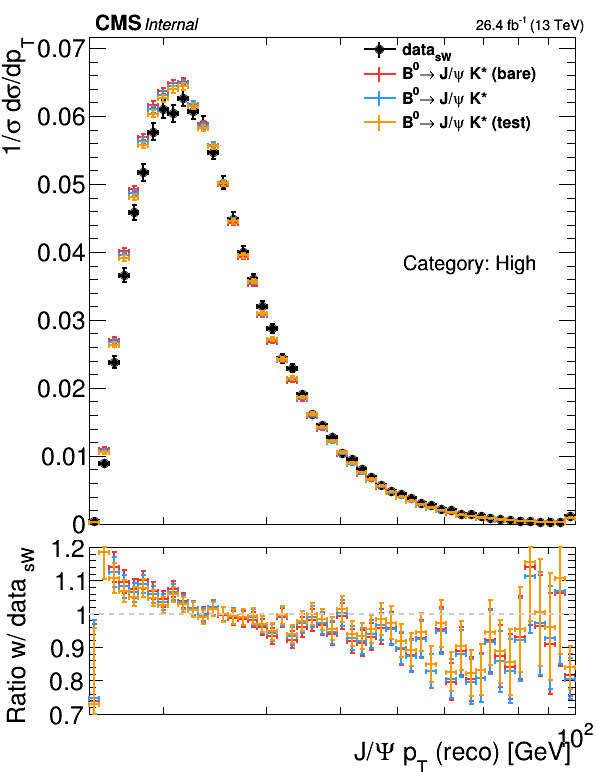

In [147]:
b = {'Low':array('d', list(np.arange(10, 50, 0.4))),
     'Mid':array('d', list(np.arange(10, 60, 0.4))),
     'High':array('d', list(np.logspace(np.log10(15), 2, 50)))}
cr = drawPt('Jpsi_pt', b[cat.name], 'J/#Psi p_{T} (reco) [GeV]', saveTag='JPsiPt_preCal')

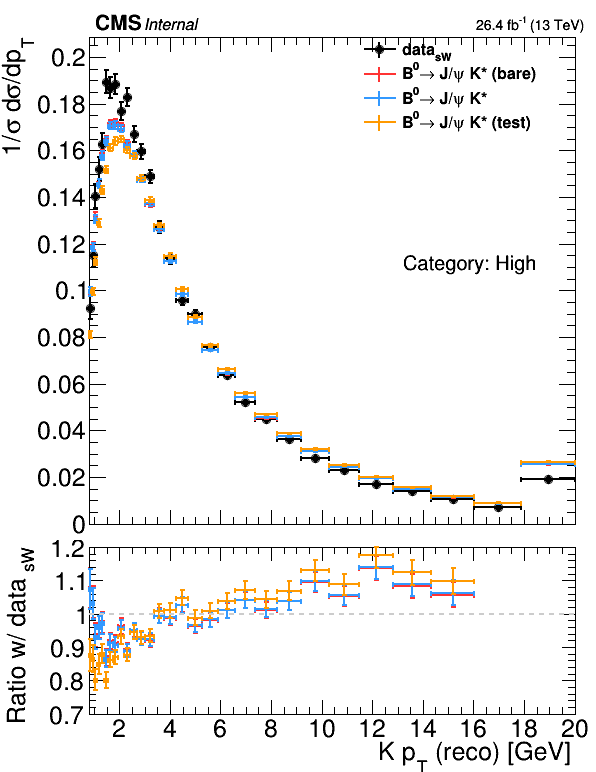

In [148]:
b = {'Low':array('d', list(np.arange(0.8, 20, 0.2))),
     'Mid':array('d', list(np.arange(0.8, 20, 0.2))),
     'High':array('d', list(np.logspace(np.log10(0.8), np.log10(20), 30)))}
cr = drawPt('K_pt', b[cat.name], 'K p_{T} (reco) [GeV]', saveTag='KPt_preCal', loglog=False)

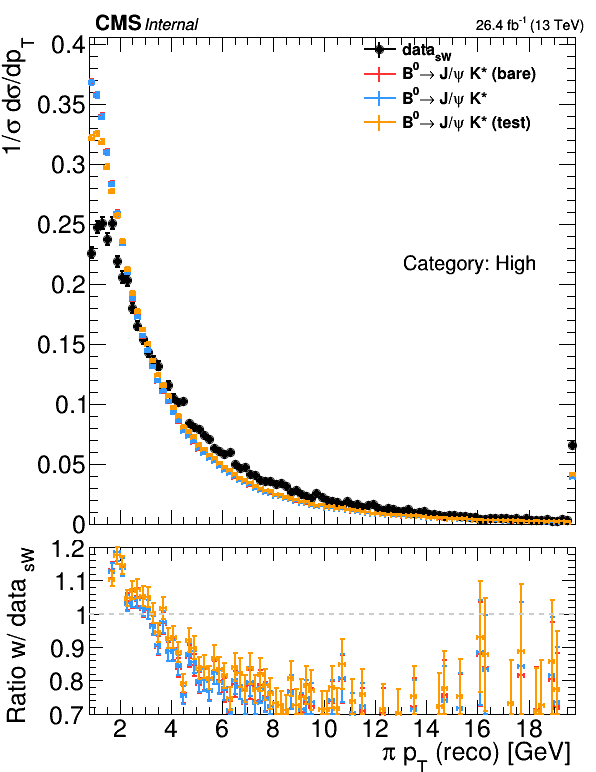

In [149]:
b = {'Low':array('d', list(np.arange(0.8, 15, 0.2))),
     'Mid':array('d', list(np.arange(0.8, 15, 0.2))),
     'High':array('d', list(np.arange(0.8, 20, 0.2)))}
cr = drawPt('pi_pt', b[cat.name], '#pi p_{T} (reco) [GeV]', saveTag='piPt_preCal', loglog=False)

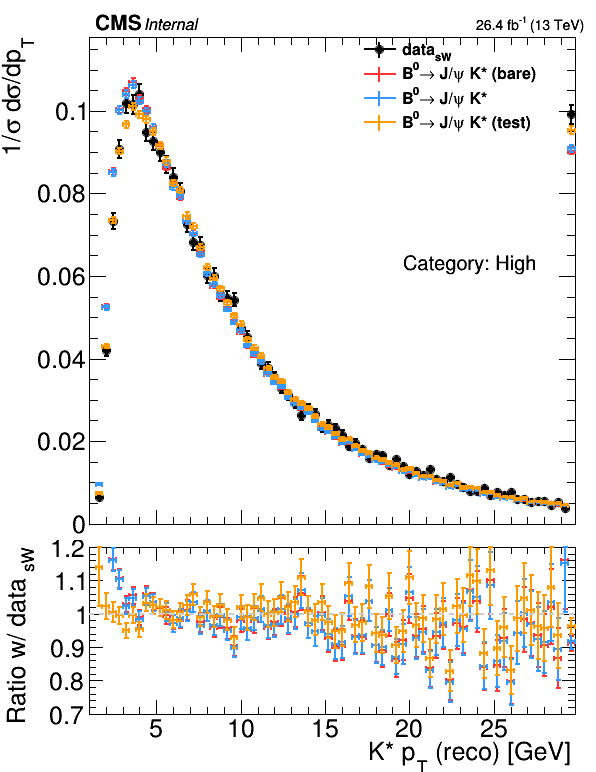

In [150]:
b = array('d', list(np.arange(1, 30, 0.4)))
cr = drawPt('Kst_pt', b, 'K* p_{T} (reco) [GeV]', saveTag='KstPt_preCal', loglog=False)

### The true B spectrum

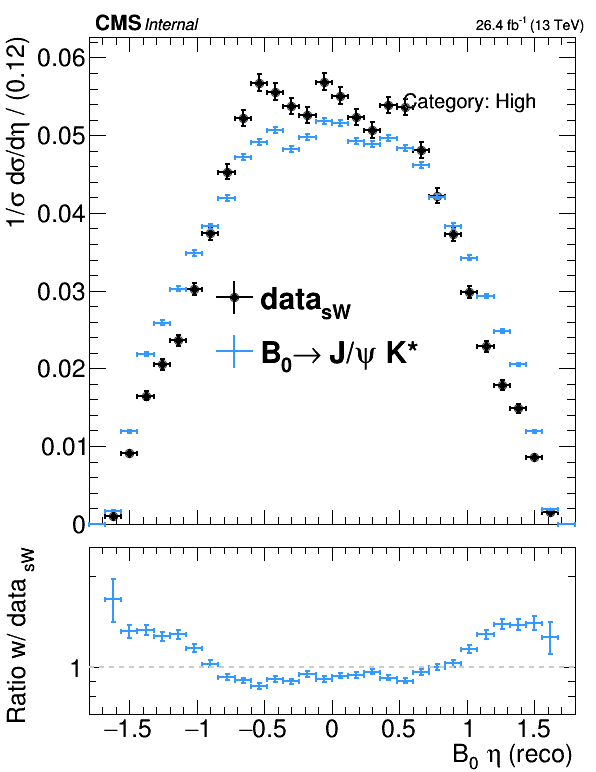

In [35]:
b=[30,-1.8,1.8]
binWdith = (b[2] - b[1])/float(b[0])
hRD = create_TH1D(dfRD['B_eta'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} #eta (reco)', 
                              '1/#sigma d#sigma/d#eta / '+'({:.2f})'.format(binWdith)],
                  binning=b,
                  scale_histo='norm',
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_eta'], name='hMCb',
                  title = 'MC',
                  scale_histo='norm', color=1,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_eta'], name='hMC', 
                  weights=dfMC['w'],
#                   title = 'MC (weights)',
                  title = 'B_{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
c = make_ratio_plot([hRD, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.7, 2.5], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY1(0.3)
c.leg.SetY2(0.5)
c.leg.SetX1(0.35)
c.leg.SetX2(0.7)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.8, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/B0etaComaprison_' + cat.name + '_' + version + '.png')
c.SaveAs(webFolder+'B0etaComaprison_' + cat.name + '_' + version + '.png')

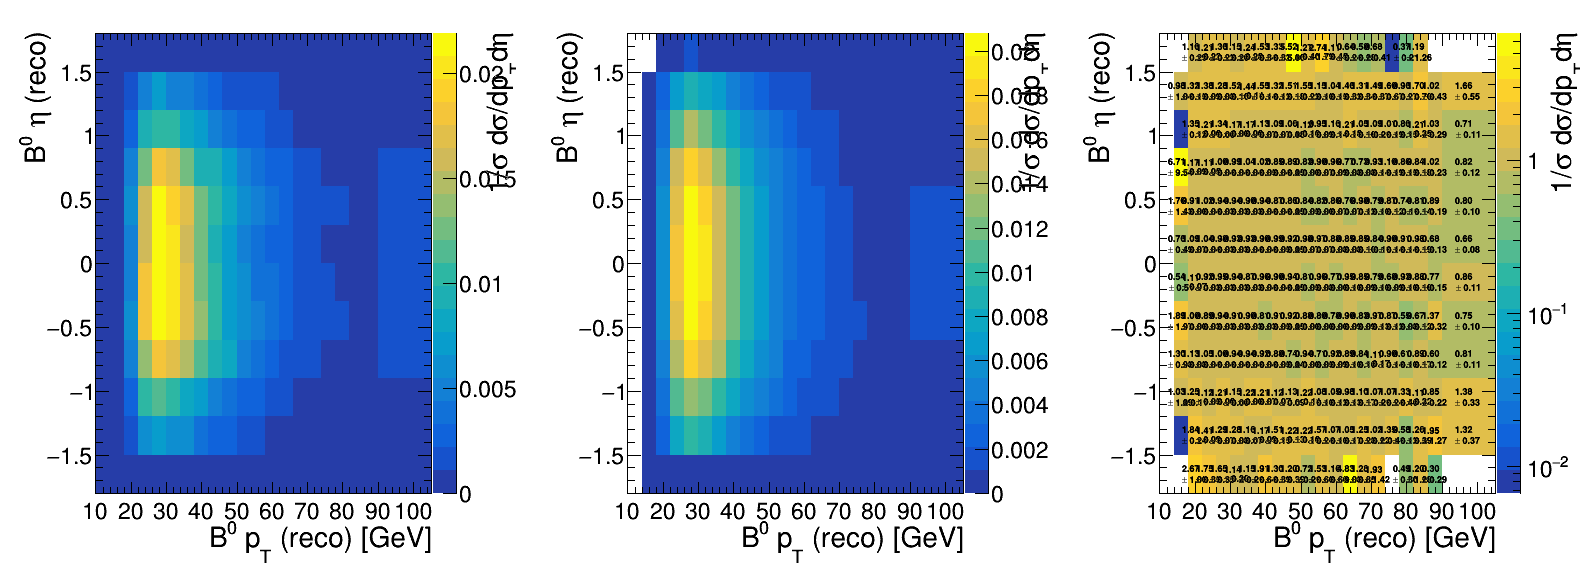

In [36]:
b = {'Low': array('d', list(np.arange(10, 50, 5)) + list(np.arange(50, 80, 10))),
     'Mid': array('d', list(np.arange(10, 60, 4)) + list(np.arange(60, 90, 8))),
     'High': array('d', list(np.arange(10, 90, 4)) + list(np.arange(90, 120, 15)))
    }
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH2D(dfRD[['B_pt', 'B_eta']].values, name='hRD_2D',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 'B^{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  binning=[b[cat.name], np.arange(-1.8,1.81, 0.3)],
                  scale_histo='norm',
                 )

hMC = create_TH2D(dfMC[['B_pt', 'B_eta']].values, name='hMC_2D',
                  weights=dfMC['w'],
                  binning=hRD.binning,
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 'B^{0} #eta (reco)', '1/#sigma d#sigma/dp_{T}d#eta'],
                  scale_histo='norm',
                  )

hRatio = hMC.Clone('hRatio')
hRatio.Divide(hRD)

cc = rt.TCanvas('c2D', 'c2D', 50, 50, 1600, 600)
cc.SetTickx(0)
cc.SetTicky(0)
cc.Divide(3)

pad = cc.cd(1)
pad.SetRightMargin(0.17)
hRD.Draw('colz')

pad = cc.cd(2)
pad.SetRightMargin(0.17)
hMC.Draw('colz')

pad = cc.cd(3)
pad.SetRightMargin(0.17)
hRatio.Draw('colz')
rt.gStyle.SetPaintTextFormat('.2f')
hRatio.Draw('texte same')
pad.SetLogz()

cc.Draw()

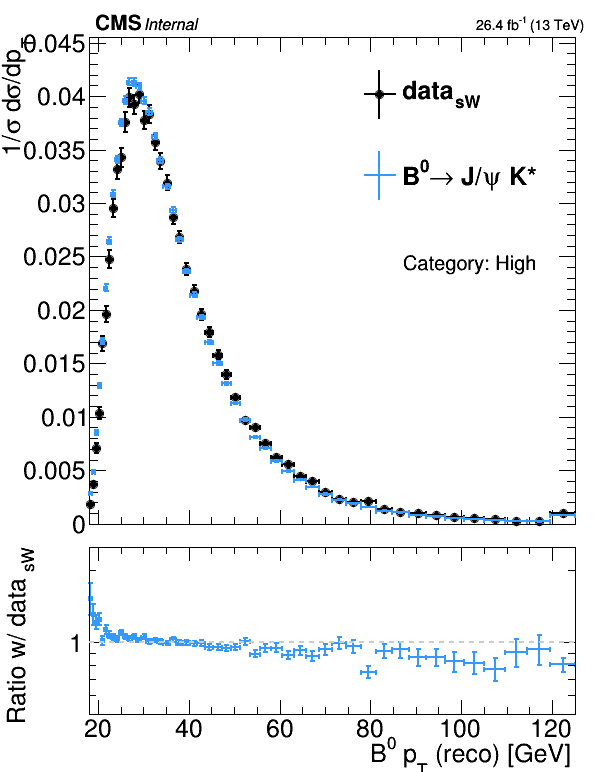

In [37]:
lowOff = 5
midOff = 10
highOff = 5
b = {'Low': array('d', list( lowOff+np.logspace(np.log10(12-lowOff), np.log10(90-lowOff), 40) )),
     'Mid': array('d', list( midOff+np.logspace(np.log10(14-midOff), np.log10(100-midOff), 45) )),
     'High': array('d', list( highOff+np.logspace(np.log10(18-highOff), np.log10(125-highOff), 50) )),
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
hRD = create_TH1D(dfRD['B_pt'], name='hRD',
                  weights=dfRD['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B^{0} p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T}'],
                  binning=b[cat.name],
                  scale_histo='norm',
                  widthNorm=True,
                  opt='overflow+underflow'
                 )
hRD.SetMarkerStyle(15)

hMCb = create_TH1D(dfMC['B_pt'], name='hMCb',
                  title = 'B^{0}#rightarrow J/#psi K* (bare)',
                  scale_histo='norm', color=1,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

hMC = create_TH1D(dfMC['B_pt'], name='hMC', 
                  weights=dfMC['w'],
                  title = 'B^{0}#rightarrow J/#psi K*',
                  scale_histo='norm', color=0,
                  widthNorm=True,
                  binning=hRD.binning, opt='overflow+underflow')

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot([hRD, hMC], ratio_bounds=[0.5, 2.5], draw_opt='E1')
# c = make_ratio_plot([hRD, hMCb, hMC], ratio_bounds=[0.5, 10], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
cr.pad2.SetLogy()
cr.leg.SetY2(0.9)
cr.leg.SetY1(0.6)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.SaveAs('../data/calibration/B0pTspectrum/fig/B0pTcomaprison_' + cat.name + '_' + version + '.png')
cr.SaveAs(webFolder+'B0pT_preCal_' + cat.name + '_' + version + '.png')

In [38]:
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb_2(x, pivFrac=0.3, lamToEnd=3):
    xPiv = pivFrac*(hRD.binning[-1] + hRD.binning[0])
    if x <= xPiv:
        dx = xPiv - x
        lam = (xPiv - hRD.binning[0])/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return -sf
    elif x > xPiv:
        dx = x - xPiv
        lam = (hRD.binning[-1] - xPiv)/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return sf

fout = open('../data/calibration/B0pTspectrum/pwWeights_{}_{}.txt'.format(cat.name, version), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    if d == 0:
        dic['w'].append(1)
        dic['w_err'].append(0)
        dic['wUp'].append(1)
        dic['wDown'].append(1)
        continue
        
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    dic['wUp'].append(max(0, r + dr *f_arb_2(pt)))
    dic['wDown'].append(max(0, r - dr * f_arb_2(pt)))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, dic['wUp'][-1], dic['wDown'][-1]]))+'\n')
fout.close()

for k,v in dic.iteritems():
    dic[k] = np.array(v)
    
pickle.dump(dic, 
            open('../data/calibration/B0pTspectrum/RatioPtSpectrum_data_over_MC_{}_{}.pkl'.format(cat.name, version), 'wb'))

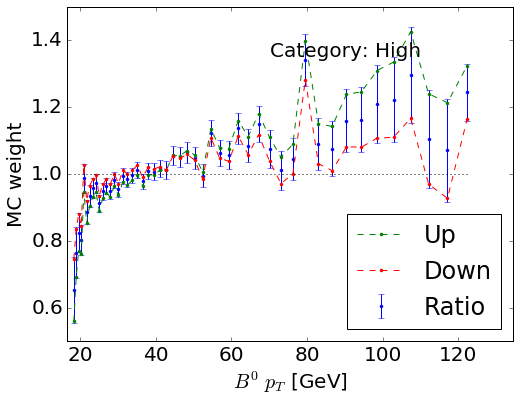

In [39]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1)
plt.xlabel('$B^0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
# plt.xscale('log')
plt.savefig('../data/calibration/B0pTspectrum/fig/ratioVSpt_' + cat.name + '_' + version + '.png')
plt.savefig(webFolder+'ratioVSpt_' + cat.name + '_' + version + '.png')


Chi2/dof = 52.14/45 (21.6%)


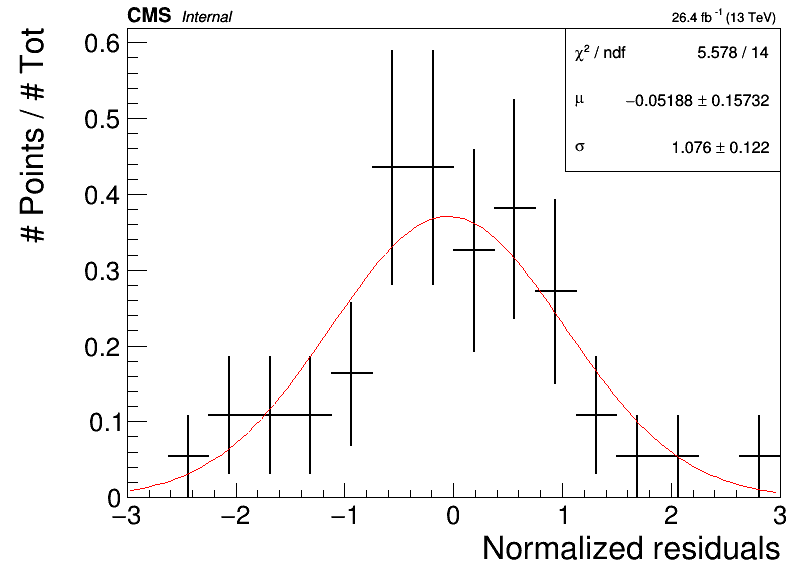

In [40]:
deg = 3
# beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov=True)
beta, covBeta = np.polyfit(dic['pt'], dic['w'], deg=deg, full=False, w=1./dic['w_err'], cov='unscaled')

res = (dic['w'] - np.polyval(beta, dic['pt']))/dic['w_err']

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[16, -3,3],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals')
textPave = h.FindObject('stats')
textPave.SetY1NDC(0.7)
textPave.SetY2NDC(0.95)

In [41]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])
    
dOut = {
    'beta': beta,
    'betaVar' : betaVar
}

pickle.dump(dOut, open('../data/calibration/B0pTspectrum/polyCoeffWeights_{}_{}.pkl'.format(cat.name, version), 'wb'))

Beta:  7.07e-07, -1.62e-04, 1.38e-02, 6.80e-01
Error: 4.18e-07, 7.82e-05, 4.31e-03, 7.05e-02


eigSigma: 7.07e-02
eigVect: 0.00, -0.00, 0.06, -1.00
Variation: 3.75e-07, -7.41e-05, 4.25e-03, -7.05e-02


eigSigma: 7.43e-04
eigVect: -0.00, 0.03, -1.00, -0.06
Variation: -1.66e-07, 2.43e-05, -7.41e-04, -4.46e-05


eigSigma: 2.77e-08
eigVect: -1.00, -0.01, -0.00, -0.00
Variation: -2.77e-08, -3.16e-10, -4.13e-12, -6.45e-14


eigSigma: 6.31e-06
eigVect: -0.01, 1.00, 0.03, 0.00
Variation: -7.19e-08, 6.31e-06, 2.06e-07, 5.79e-09


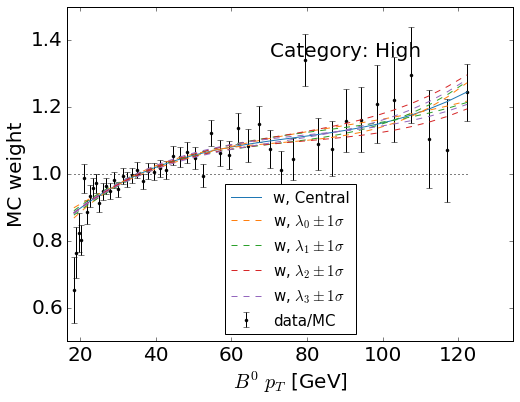

In [42]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.k', label='data/MC')

plt.plot(dic['pt'], np.polyval(beta, dic['pt']), '-', color='#1f77b4', label='w, Central')

colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], dic['pt'])
    yM = np.polyval(beta-betaVar[i], dic['pt'])
    plt.plot(dic['pt'], yP, '--', color=colors[i], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(dic['pt'], yM, '--', color=colors[i])
    
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$B^0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
plt.savefig('../data/calibration/B0pTspectrum/fig/polyCal_weightsVSpt_' + cat.name + '_' + version + '.png')
plt.savefig(webFolder+'polyCal_weightsVSpt_' + cat.name + '_' + version + '.png')

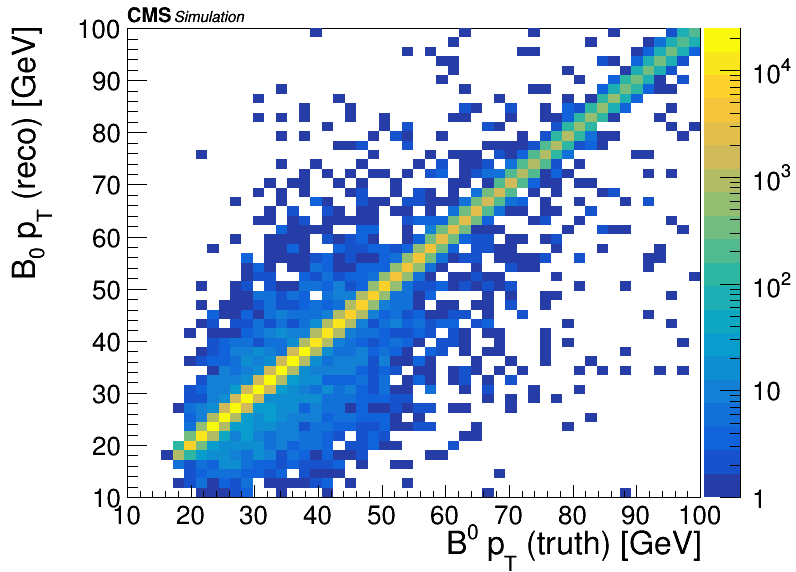

In [43]:
hMC2D = create_TH2D(dfMC[['B_pt', 'MC_B_pt']].values, name='hMC', title='',
                axis_title=['B^{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=[50, 10, 100, 50, 10, 100]
               )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

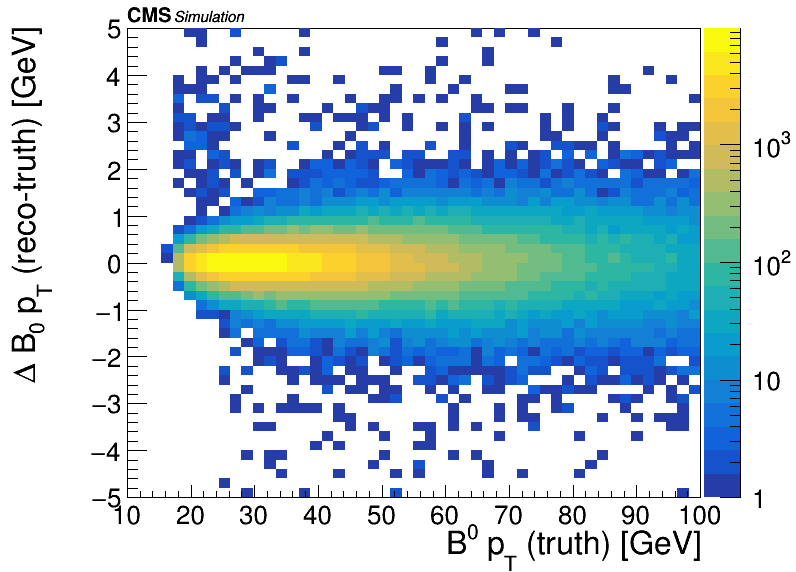

In [44]:
hMC2D = create_TH2D(np.column_stack((dfMC['MC_B_pt'], dfMC['B_pt'] - dfMC['MC_B_pt'])),
                    name='hMC', title='',
                    axis_title=['B^{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', 'Events'],
                    binning=[50, 10, 100, 50, -5, 5],
                    weights=dfMC['MC_idxMatch']
                   )

CMS_lumi.extraText = '     Simulation'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'], mR=0.12)
c.SetLogz()

4675
121945
176110
44242
17813


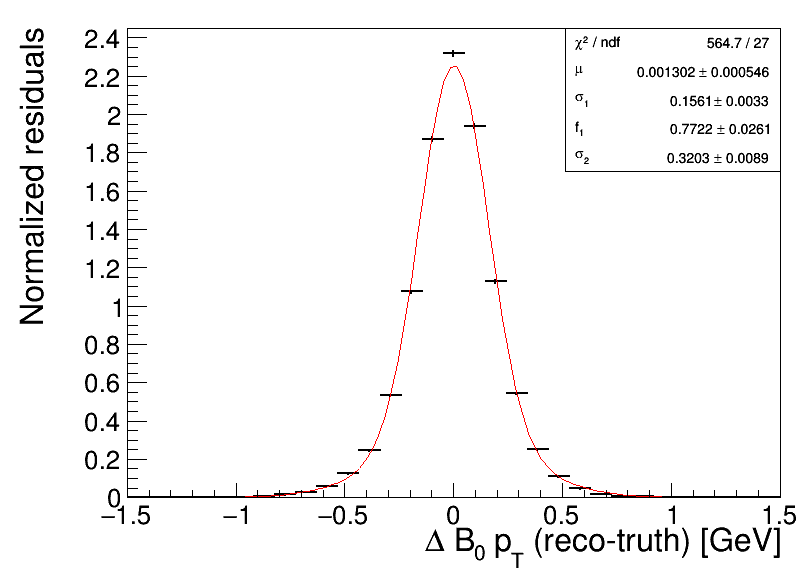

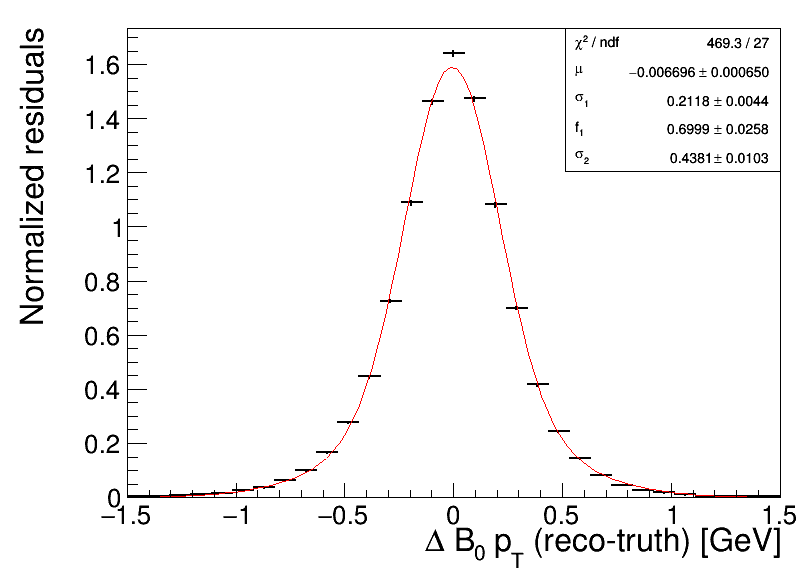

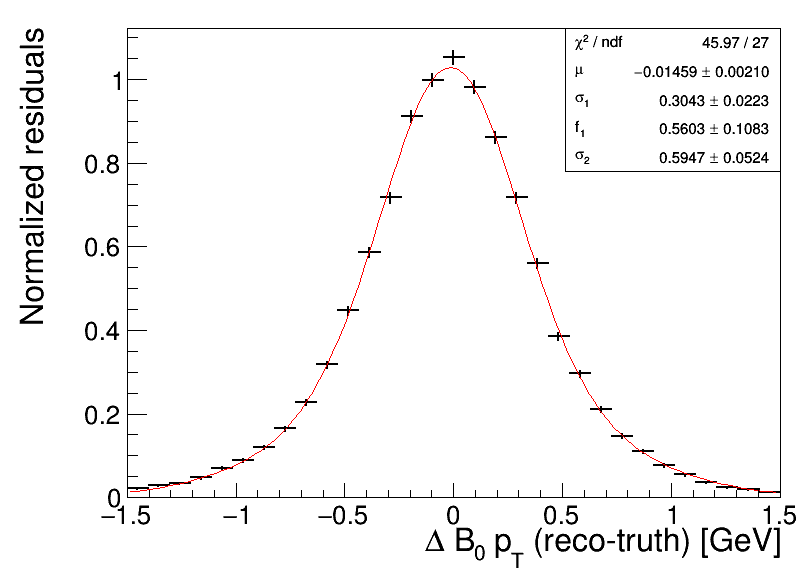

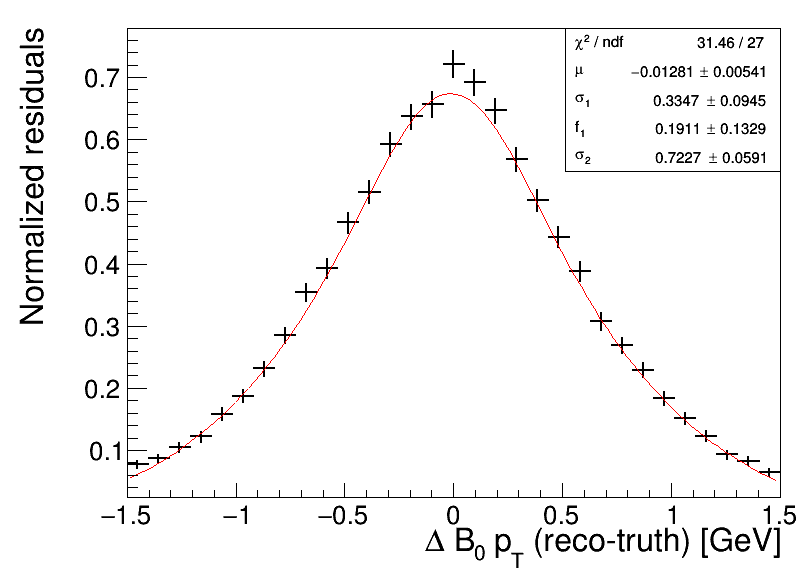

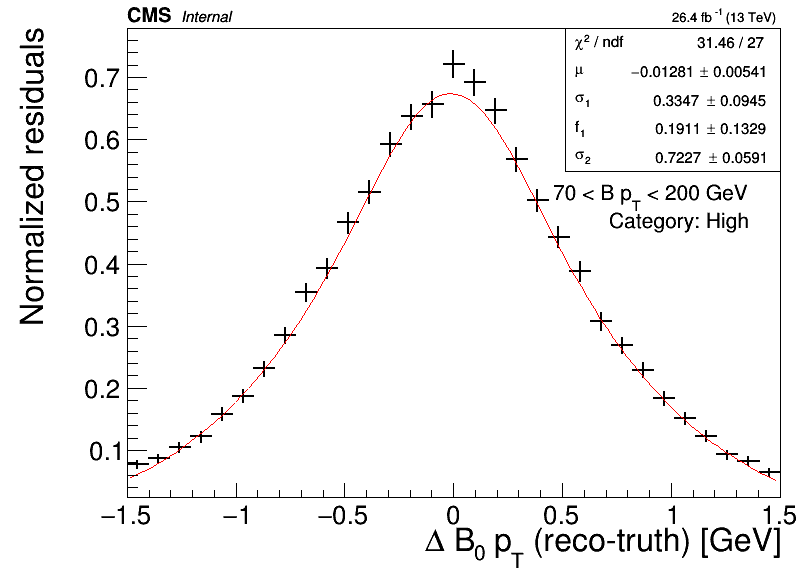

In [74]:
ptBins = [0, 20, 30, 50, 70, 200]

canvases = []

for i in range(len(ptBins)-1):
    ptLow = ptBins[i]
    ptHigh = ptBins[i+1]
    sel = np.logical_and(dfMC['MC_B_pt'] > ptLow, dfMC['MC_B_pt'] < ptHigh)
    print np.sum(sel)
    h = create_TH1D(dfMC['B_pt'][sel] - dfMC['MC_B_pt'][sel], binning=[31, -1.5, 1.5],
                    axis_title=['#Delta B_{0} p_{T} (reco-truth) [GeV]', 'Normalized residuals'],
                    scale_histo='norm', widthNorm=True
                   )
#     h.Scale(h.Integral()*h.GetBinWidth(1))

    funcStr =  '[2]*exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi))
    funcStr += ' + '
    funcStr += '(1-[2])*exp(-(x-[0])*(x-[0])/(2*[3]*[3]))/({:.4f}*[3])'.format(np.sqrt(2*np.pi))
    fGaus = rt.TF1('fFit', funcStr, -2, 2)
    fGaus.SetParameters(0, 0.3, 0.3, 0.8)
    fGaus.SetParNames('#mu', '#sigma_{1}', 'f_{1}', '#sigma_{2}')
    h.Fit(fGaus, 'QWL')
    c = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='cRes'+str(i))
    textPave = h.FindObject('stats')
    textPave.SetY1NDC(0.7)
    textPave.SetY2NDC(0.95)
    catText.DrawLatexNDC(0.94, 0.6, 'Category: {}'.format(cat.name))
    catText.DrawLatexNDC(0.94, 0.65, '{} < B p_{{T}} < {} GeV'.format(ptLow, ptHigh))
    webFolderAux = webFolder + 'BpTresolution/'
    if not os.path.isdir(webFolderAux):
        os.system('mkdir -p '+webFolderAux)
        os.system('cp {}index.php '.format(webFolder) + webFolderAux)
    c.SaveAs(webFolderAux + cat.name + '_ptBin'+str(i)+'.png')
    canvases.append([c, h, fGaus])

In [46]:
from pT_calibration_reader import pTCalReader
cal_pT = pTCalReader(
    calibration_file='../data/calibration/B0pTspectrum/polyCoeffWeights_{}_{}.pkl'.format(cat.name, version)
)

In [47]:
h_var = {}
h_var['C'] = create_TH1D(dfMC['B_pt'], name='h_var_C', binning=hRD.binning, opt='underflow+overflow',
                         weights=cal_pT.getWeights(dfMC['MC_B_pt'], 0)*dfMC['w'])
norm = float(h_var['C'].Integral())
h_var['C'].Scale(1./norm, 'width')

mVar = np.array(betaVar)
nIter = 1000
binContent = np.zeros((nIter, hRD.GetNbinsX()))
pb = ProgressBar(nIter)
for itx in range(nIter):
    pb.show(itx)
    p = beta + np.sum(np.random.normal(size=(4,1))*mVar, axis=0)
    
    wPt = np.polyval(p, dfMC['B_pt'])
    hAux = create_TH1D(dfMC['B_pt'], name='hAux', binning=hRD.binning, opt='underflow+overflow', 
                       weights=wPt*dfMC['w'])
    hAux.Scale(1./norm, 'width')
    
    for i in range(1, binContent.shape[1]+1):
        binContent[itx, i-1] = hAux.GetBinContent(i)

for n, var in {'Down':-1, 'Up':1}.iteritems():
    h_var[n] = h_var['C'].Clone('h_var_'+n)
    content = np.percentile(binContent, q=100*sps.norm.cdf(var), axis=0)
    for i in range(1, content.shape[0]+1):
        h_var[n].SetBinContent(i, content[i-1]) 

[####################]  100% - Tot. time: 26.8 s


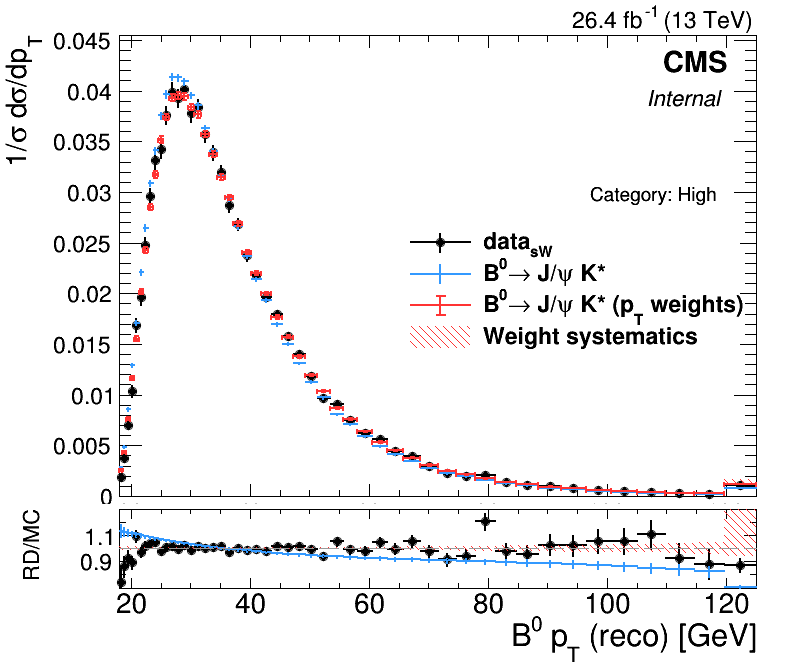

In [48]:
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kRed-4)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kRed-4)
gr_sys.SetFillColor(rt.kRed-4)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.5, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, 'B^{0}#rightarrow J/#psi K*', 'le')
leg.AddEntry(gr_stat, 'B^{0}#rightarrow J/#psi K* (p_{T} weights)', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name))
CMS_lumi.extraText = '     Internal'
CMS_lumi.integrated_lumi = lumi_tot
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.1
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kRed-4)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kRed-4)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/closure_' + cat.name + '_'+version+'.png')
c.SaveAs(webFolder+'closure_' + cat.name + '_'+version+'.png')

# Closure plots

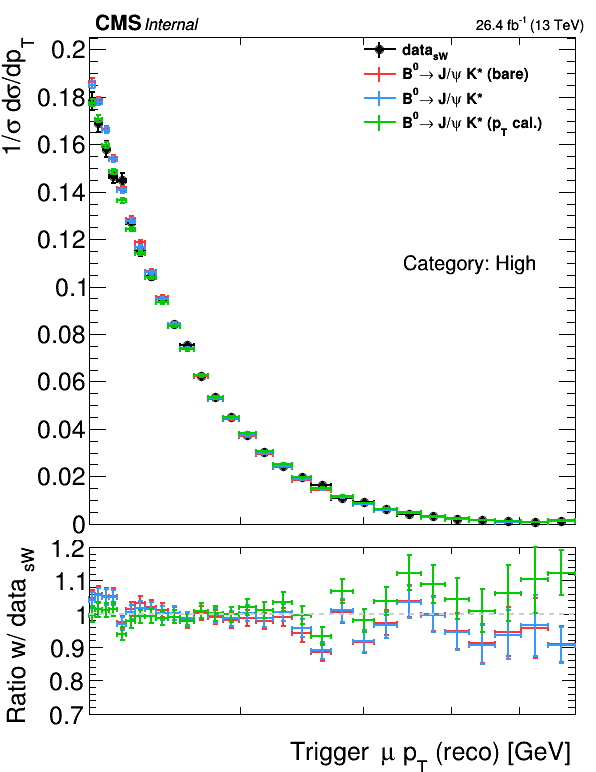

In [49]:
b = {'Low': array('d', list(np.arange(7, 9.4, 0.1)) + [9.4]),
     'Mid': array('d', list(np.arange(9, 12.2, 0.1)) +[12.2]),
     'High': array('d', list(10+np.logspace(np.log10(12.2-10), np.log10(50), 30)))
    }

cr = drawPt('trgMu_pt', b[cat.name], 'Trigger #mu p_{T} (reco) [GeV]', saveTag='trgMuPt_postCal', withBptCorr=True)

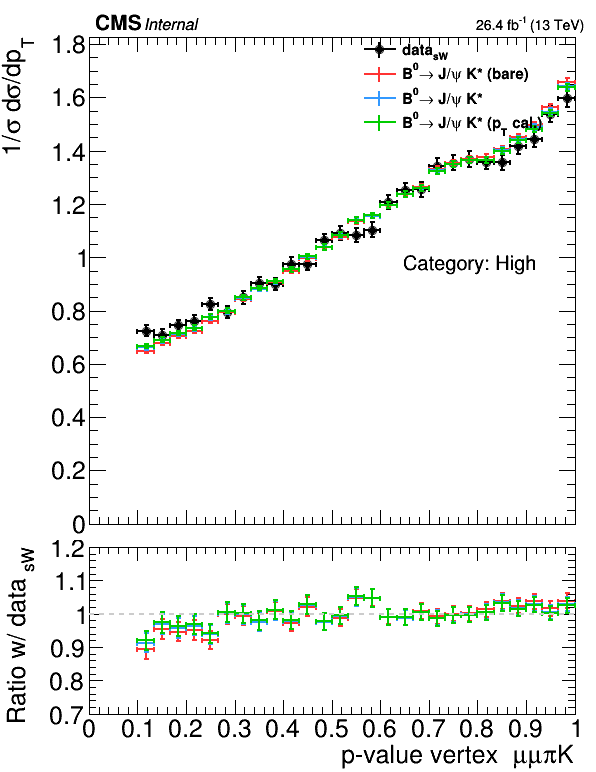

In [50]:
cr = drawPt('pval_mumupiK', [30, 0, 1], 
            'p-value vertex #mu#mu#piK', loglog=False,
            saveTag='trgMuPt_postCal', withBptCorr=True)

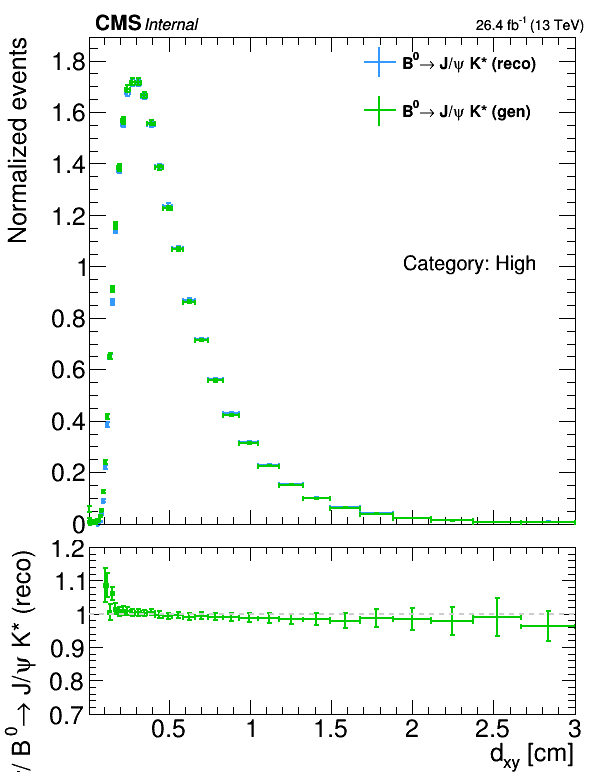

In [51]:
hMC = create_TH1D(dfMC['dxy_vtxB_PV'], name='hMC', 
                  weights=dfMC['w'],
                  title = 'B^{0}#rightarrow J/#psi K* (reco)',
                  scale_histo='norm',
                  widthNorm=True,
                  color=0,
                  axis_title = ['d_{xy} [cm]', 'Normalized events'],
                  binning=np.logspace(np.log10(0.01), np.log10(3), 50), opt='overflow+underflow')


hMCt = create_TH1D(dfMC['MC_dxy_vtxB'], name='hMCt', 
              weights=dfMC['w'],
              title = 'B^{0}#rightarrow J/#psi K* (gen)',
              scale_histo='norm', color=2,
              widthNorm=True,
              binning=hMC.binning, opt='underflow+overflow')
    
h_list = [hMC, hMCt]

CMS_lumi.extraText = '      Internal'
cr = make_ratio_plot(h_list, ratio_bounds=[0.7, 1.2], draw_opt='E1')
CMS_lumi.CMS_lumi(cr, -1, 0)
cr.pad1.SetTopMargin(0.07)
cr.pad1.SetRightMargin(0.035)
cr.pad2.SetRightMargin(0.035)
# cr.pad1.SetLogx()
# cr.pad2.SetLogx()
cr.leg.SetY2(0.93)
cr.leg.SetY1(0.75)
cr.leg.SetX1(0.6)
cr.Draw()

cr.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
cr.dnd2 = h_list